In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 7591: 5, 7607: 40, 7621: 65, 7627: 9, 7630: 31, 7643: 34, 7650: 13, 7661: 83, 7690: 6, 7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [3]:
lr = LinearRegression()

# Single element prediction

In [4]:
def init_x(data_list, data_name):
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                one_data = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        one_data += data_station[data_name][k]
                    else:
                        year_position = k
                        break
                data_list[str(provinces[i]) + "_" + str(j)] = one_data

In [5]:
def init_y(data_list):
    for i in data_list:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_rdt[i] = rdt[0]

In [6]:
def init_list(data_list):
    temp_data_list = []
    temp_rdt_list = []

    for i in total_rdt:
        if i in data_list:
            temp_data_list.append(np.array([data_list[i]]))
            temp_rdt_list.append(total_rdt[i])

    temp_data_list = np.array(temp_data_list)
    temp_rdt_list = np.array(temp_rdt_list)
    
    return temp_data_list, temp_rdt_list

In [7]:
def init(data_list):
    init_y(data_list)
    return init_list(data_list)

In [8]:
def predict_zero():
    predict_zero = rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - rdt_array) ** 2).sum() / len(rdt_array))
    rRMSE = RMSE / rdt_array.mean()
    
    return rRMSE

In [9]:
def predict_n(n, times):
    if n == 0:
        return predict_zero(), 0.0

    sum_RMSE = 0
    coef = np.array([0.0 for i in range(n)])
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        coef += lr.coef_
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times, coef / times

In [10]:
def test_degree_n(times):
    degree = np.linspace(start, end, end - start + 1)
    for i in degree:
        rRMSE_degree[crop + "_" + i.astype(int).astype(str)], coeffs[crop + "_" + i.astype(int).astype(str)] = predict_n(i.astype(int), times)

In [11]:
def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.xticks(np.arange(start, end + 1, 1))
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(start, end, end - start + 1)
        for i in range(start, end - start + 1):
            rRMSE_plot.append(rRMSE_degree[crop + "_" + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops)

## rr24

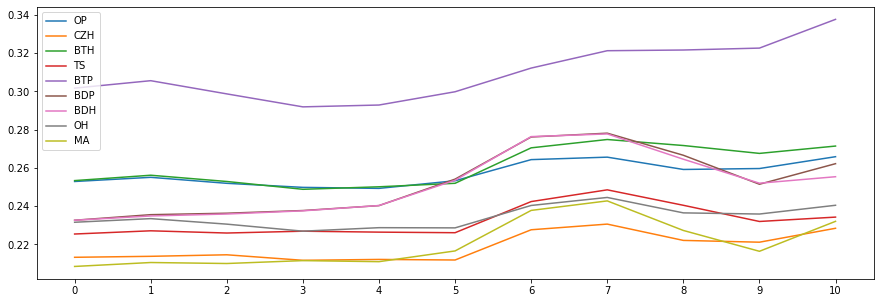

In [12]:
start = 0
end = 10
times = 10000
total_rain = {}

rRMSE_degree = {}
coeffs = {}

init_x(total_rain, "rr24")

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rain)

    test_degree_n(times)

draw()

In [13]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_4': 0.24933545516133696,
 'CZH_3': 0.21173321529672545,
 'BTH_3': 0.24885159542908114,
 'TS_0': 0.2254771996904205,
 'BTP_3': 0.29194940021771615,
 'BDP_0': 0.23267610695447274,
 'BDH_0': 0.23267610695447274,
 'OH_3': 0.22696145849771368,
 'MA_0': 0.20852417057938513}

In [14]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_4': array([ 7.91927758e-11, -1.60426957e-07,  6.02838990e-05,  2.55851774e-02]),
 'CZH_3': array([ 2.86107371e-08, -6.19942928e-05,  3.42429997e-02]),
 'BTH_3': array([ 8.23742943e-08, -1.96084097e-04,  1.31180098e-01]),
 'TS_0': 0.0,
 'BTP_3': array([ 1.06291820e-07, -2.55118663e-04,  1.71879656e-01]),
 'BDP_0': 0.0,
 'BDH_0': 0.0,
 'OH_3': array([ 6.83337055e-08, -1.63730249e-04,  1.12308594e-01]),
 'MA_0': 0.0}

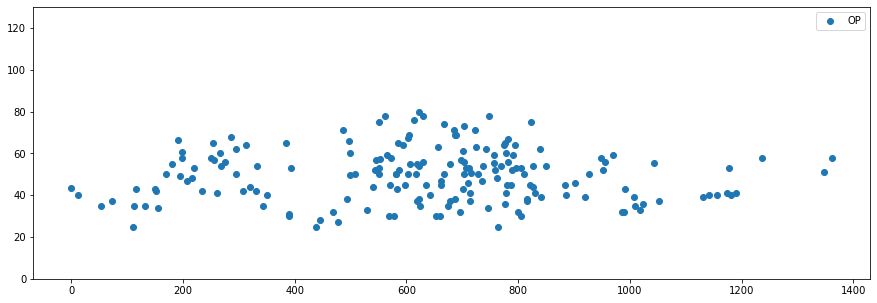

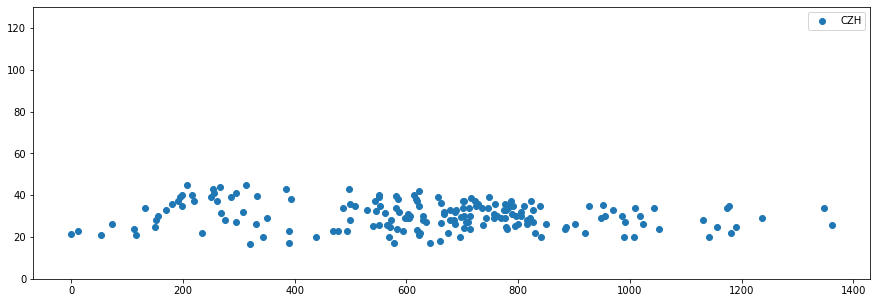

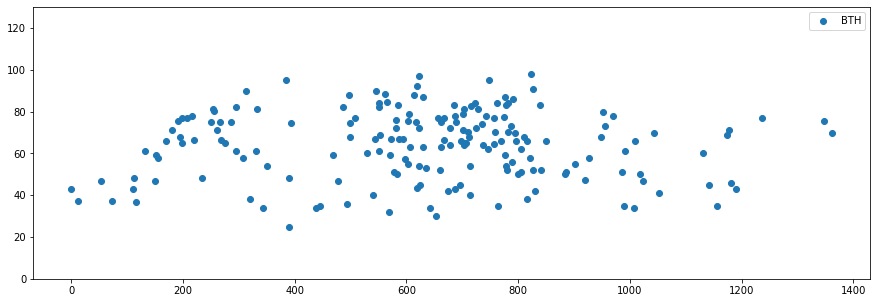

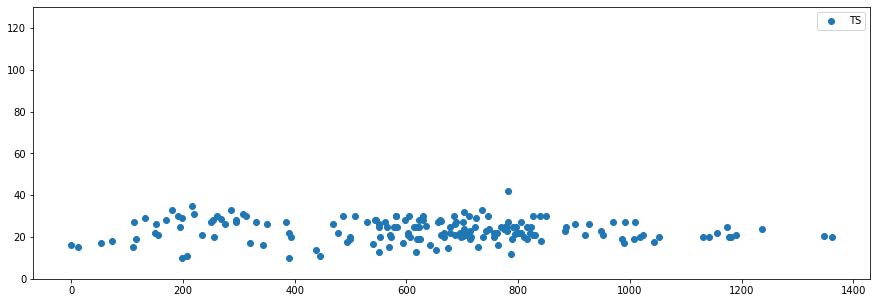

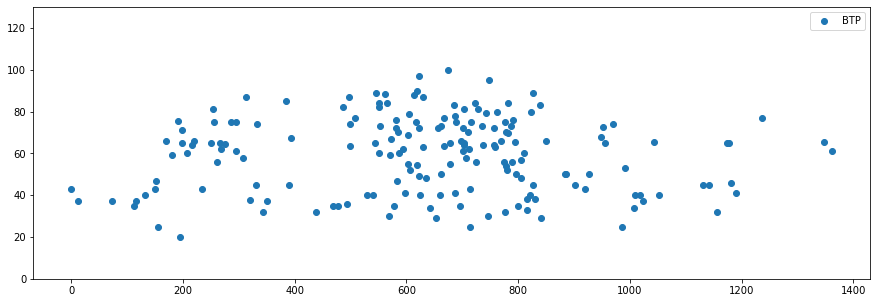

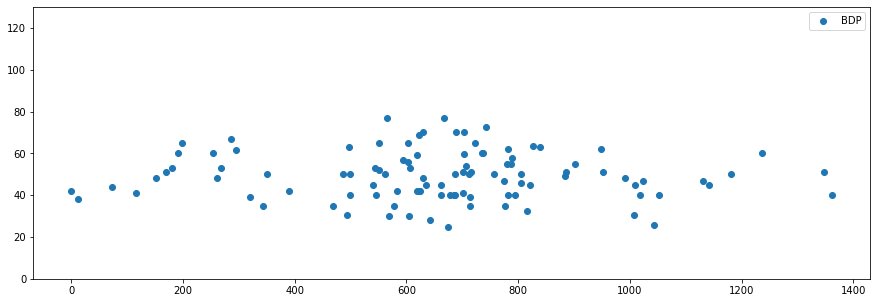

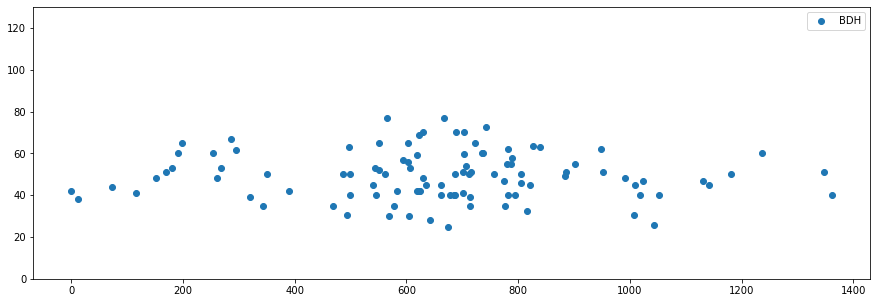

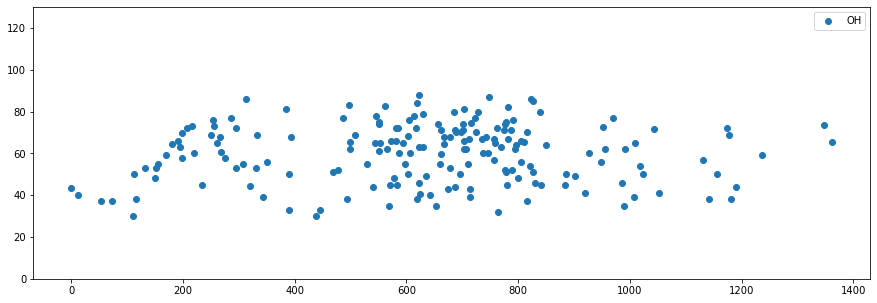

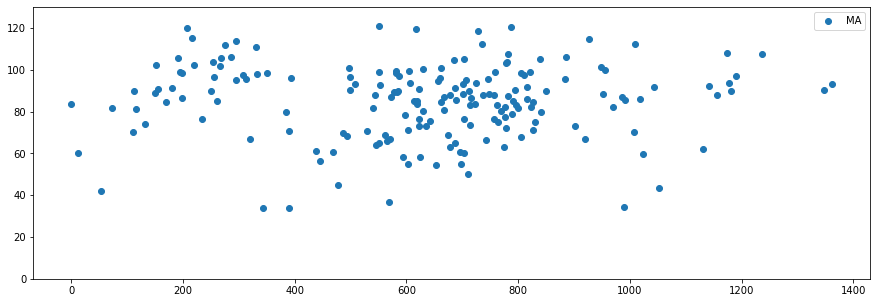

In [15]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rain)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    plt.legend([crop])

## DJ_0

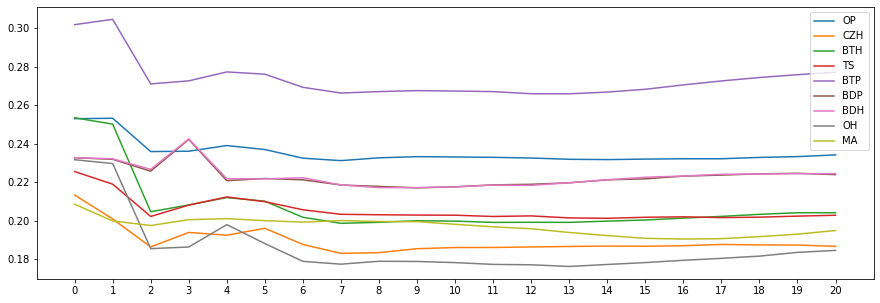

In [16]:
start = 0
end = 20
times = 10000
total_rad_0 = {}

rRMSE_degree = {}
coeffs = {}

init_x(total_rad_0, "DJ_0")

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_0)

    test_degree_n(times)

draw()

In [17]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_7': 0.23114445118330104,
 'CZH_7': 0.18299712906779744,
 'BTH_7': 0.198592169471931,
 'TS_14': 0.20119960106602386,
 'BTP_13': 0.265831536963611,
 'BDP_9': 0.21702166180186483,
 'BDH_8': 0.21712649619670807,
 'OH_13': 0.1762065710433959,
 'MA_16': 0.1904369734265786}

In [18]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_7': array([ 1.69922466e-23, -2.59879692e-19,  1.30110895e-15, -2.13573318e-12,
        -1.72273866e-15, -8.44970808e-19, -2.89752678e-22]),
 'CZH_7': array([ 1.16102590e-23, -1.80425292e-19,  9.25791092e-16, -1.57923280e-12,
        -1.27706191e-15, -6.27938674e-19, -2.16110675e-22]),
 'BTH_7': array([ 2.13016217e-23, -3.22159604e-19,  1.58534186e-15, -2.54184272e-12,
        -2.04912932e-15, -1.00419495e-18, -3.43739036e-22]),
 'TS_14': array([ 3.93293862e-50, -6.19054738e-46,  3.23690109e-42, -5.65761043e-39,
        -4.23484322e-42, -1.98975380e-45, -7.51195282e-49, -2.49223973e-52,
        -7.58977212e-56, -2.17296400e-59, -5.92096515e-63, -1.53563620e-66,
        -3.69078207e-70, -7.18440861e-74]),
 'BTP_13': array([-1.70769559e-45,  3.00073117e-41, -1.75096085e-37,  3.38816024e-34,
         2.57623951e-37,  1.23015927e-40,  4.72140626e-44,  1.59245506e-47,
         4.92585330e-51,  1.42761922e-54,  3.89561386e-58,  9.76792778e-62,
         1.96939059e-65]),
 'BDP_9': array([

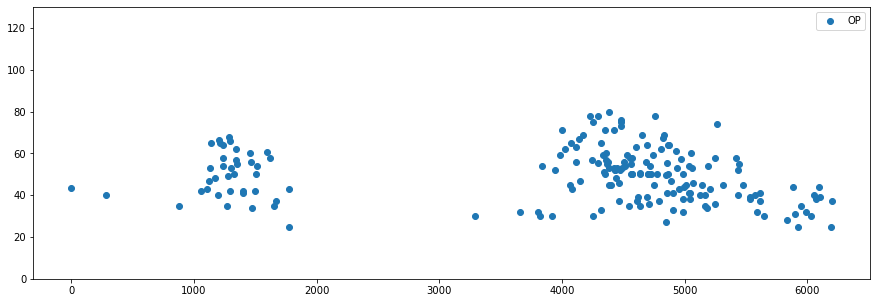

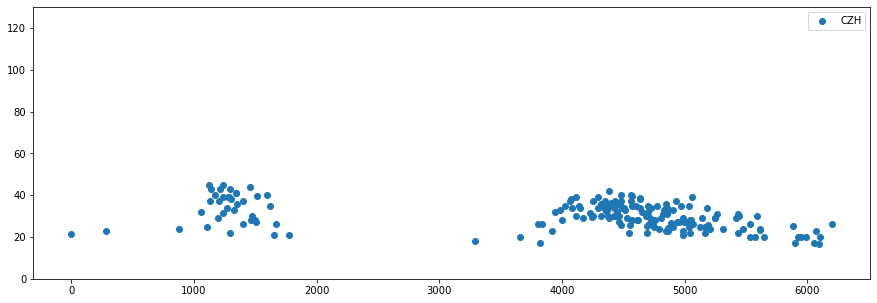

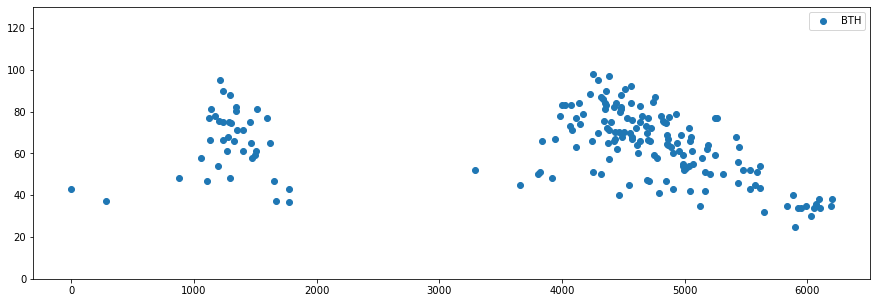

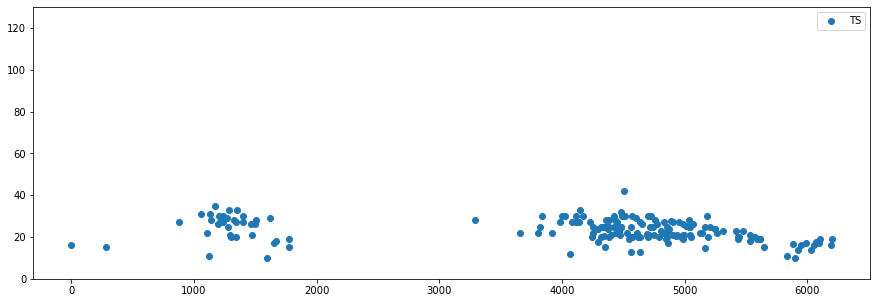

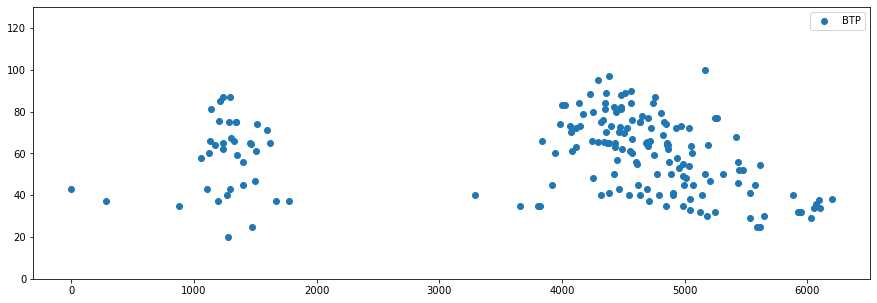

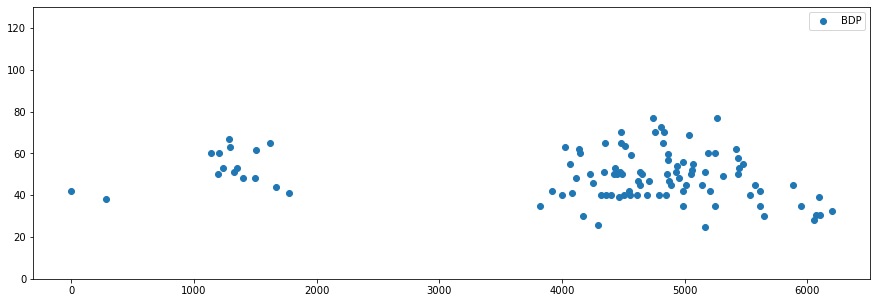

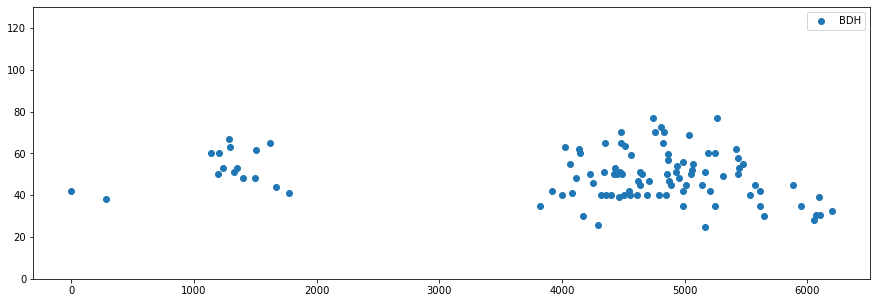

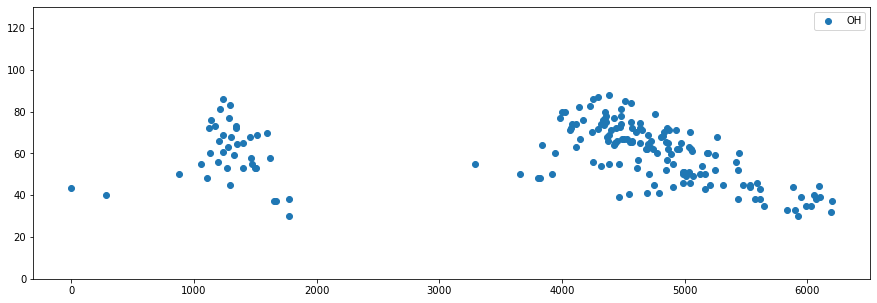

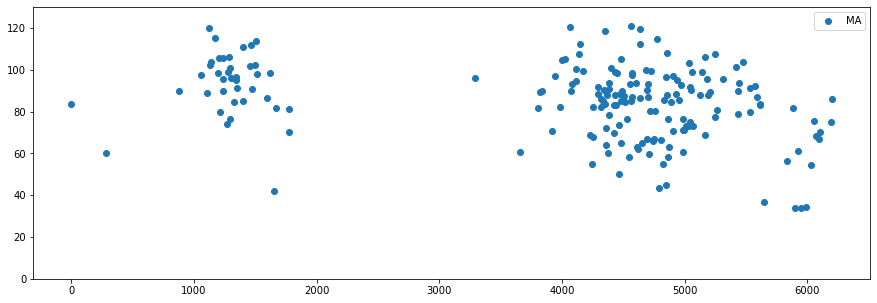

In [19]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_0)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    plt.legend([crop])

## DJ_6

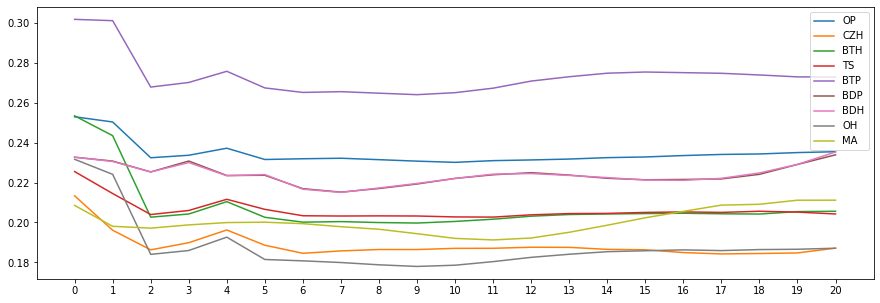

In [20]:
start = 0
end = 20
times = 10000
total_rad_6 = {}

rRMSE_degree = {}
coeffs = {}

init_x(total_rad_6, "DJ_6")

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_6)

    test_degree_n(times)

draw()

In [21]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_10': 0.230102867234913,
 'CZH_17': 0.18421239238949635,
 'BTH_9': 0.19968756670135734,
 'TS_11': 0.20266548973427845,
 'BTP_9': 0.26401210957331017,
 'BDP_7': 0.21517598585268943,
 'BDH_7': 0.21502518641925372,
 'OH_9': 0.17793981571247078,
 'MA_11': 0.19121692955467956}

In [22]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_10': array([-7.53010250e-33,  8.32813174e-29, -3.04528020e-25,  3.66630053e-22,
         4.54735428e-25,  3.55527548e-28,  2.23648982e-31,  1.22682812e-34,
         5.94251583e-38,  2.27789071e-41]),
 'CZH_17': array([ 1.38167810e-57, -1.58703464e-53,  6.10042605e-50, -7.85634645e-47,
        -8.93069578e-50, -6.36824513e-53, -3.64598313e-56, -1.83290304e-59,
        -8.45237383e-63, -3.66499309e-66, -1.51713708e-69, -6.05395798e-73,
        -2.34253049e-76, -8.81018350e-80, -3.20843758e-83, -1.10528857e-86,
        -3.18931017e-90]),
 'BTH_9': array([-2.34814760e-29,  2.67392235e-25, -1.00431461e-21,  1.23428814e-18,
         1.56094790e-21,  1.24104821e-24,  7.86341222e-28,  4.20466366e-31,
         1.73093098e-34]),
 'TS_11': array([ 4.88217490e-37, -4.83205460e-33,  1.59479099e-29, -1.78453006e-26,
        -2.16957701e-29, -1.66229081e-32, -1.02672955e-35, -5.57771571e-39,
        -2.76136903e-42, -1.23985320e-45, -4.49350067e-49]),
 'BTP_9': array([-3.03525627e-29,  3.4426141

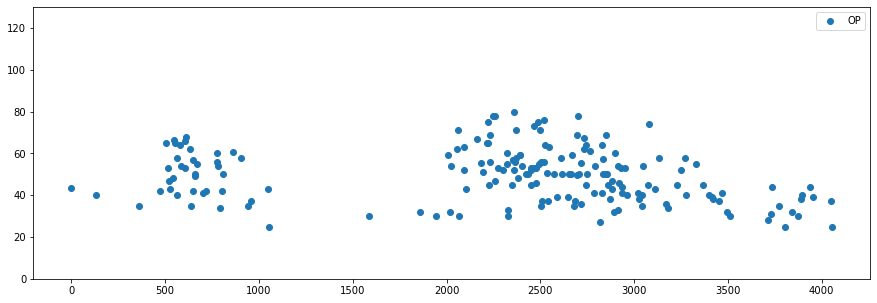

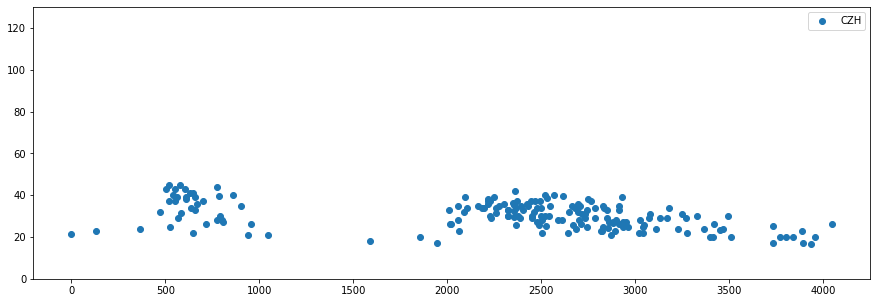

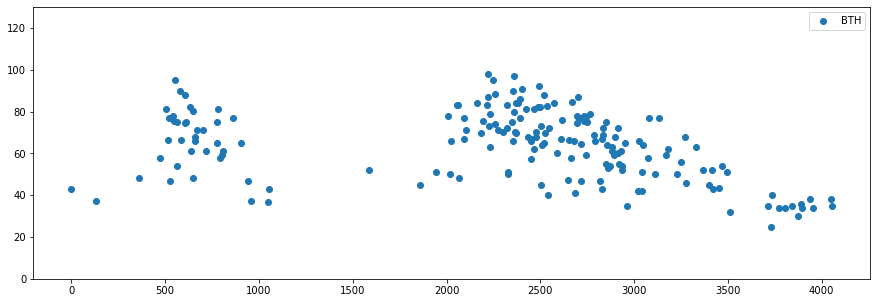

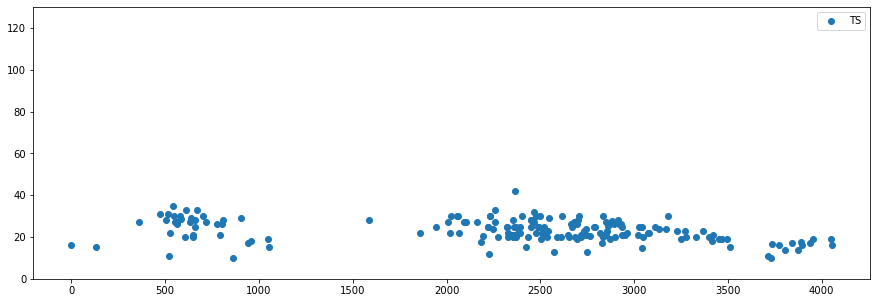

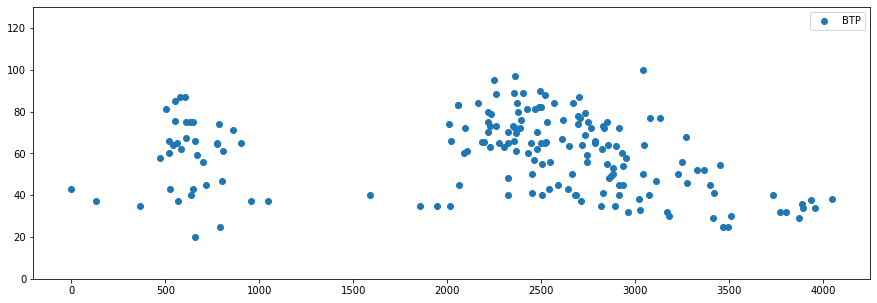

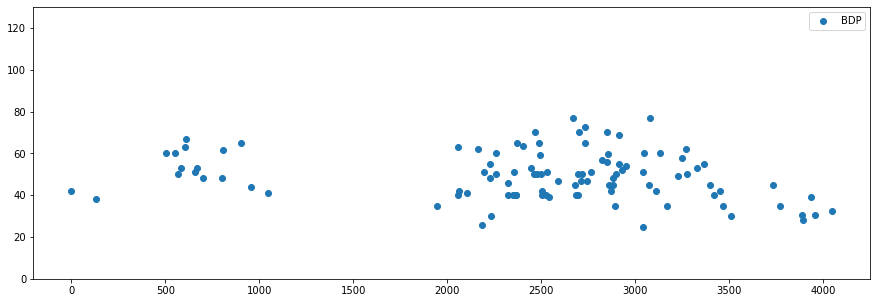

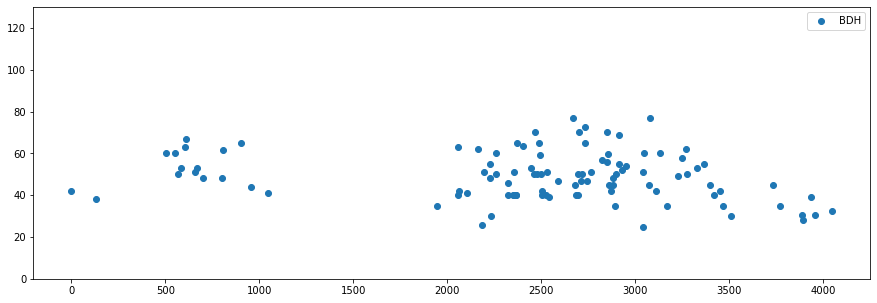

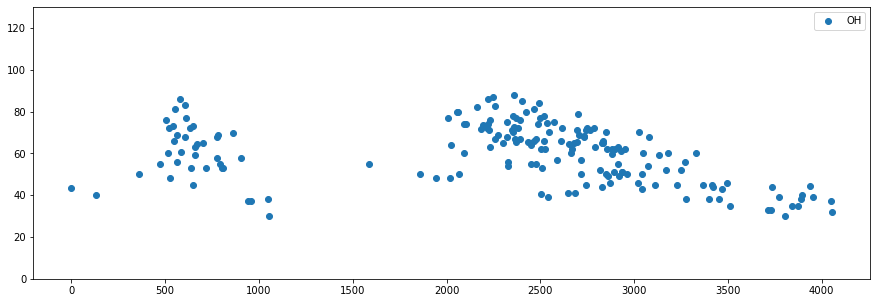

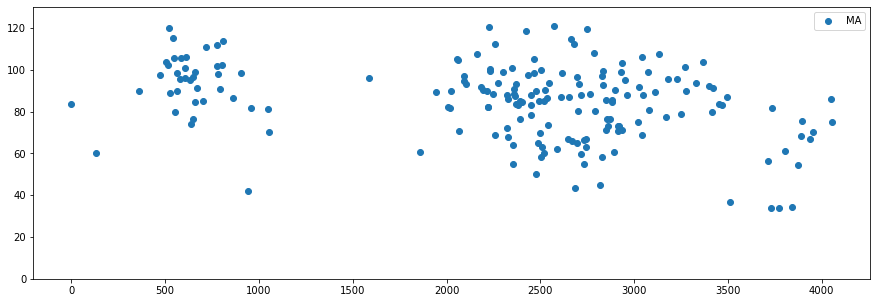

In [23]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_6)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    plt.legend([crop])